# Alignment algorithm with graphemes

This is the same procedure as before, but we want to get individual graphemes out - instead of simply word boundaries.

In [ ]:
!pip install datasets[audio]

In [2]:
import datasets
from huggingface_hub import HfFileSystem
from pathlib import Path
from IPython.display import Audio, display, HTML
import matplotlib.pyplot as P
import numpy as np
import torch
from transformers import Wav2Vec2Processor, AutoModelForCTC
import re
from typing import Tuple, List

Let's load up some test data from our corpus:

In [3]:
%mkdir -p data
fs = HfFileSystem()
test_file=Path('data/train-00000-of-00326.parquet')
if not test_file.exists():
  fs.get_file(f'datasets/classla/ParlaSpeech-HR/{test_file}',str(test_file))
ds=datasets.load_dataset('data',split='train')
ds

Dataset({
    features: ['id', 'audio', 'text', 'text_normalised', 'words', 'audio_length', 'date', 'speaker_name', 'speaker_gender', 'speaker_birth', 'speaker_party', 'party_orientation', 'party_status'],
    num_rows: 2662
})

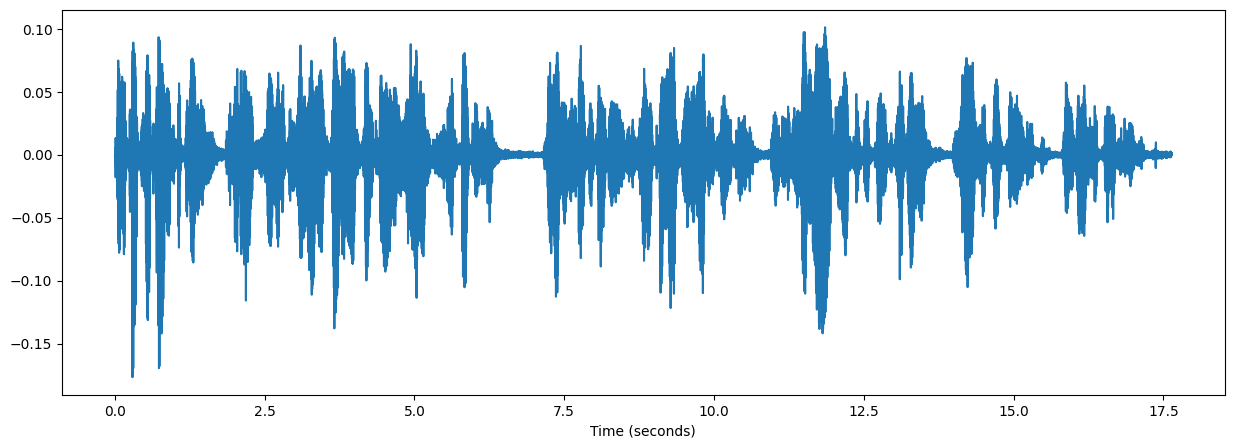

In [4]:
uid=ds[10]['id']
audio=ds[10]['audio']['array']
text=ds[10]['text_normalised']

P.figure(figsize=(15,5))
P.plot(np.linspace(0,audio.size/16000,audio.size),audio)
P.xlabel('Time (seconds)')

display(Audio(audio,rate=16000))

display(HTML(f'<p>{uid}: {text}</p>'))

Next let's load HR model:

In [5]:
w2v2_model = 'classla/wav2vec2-large-slavic-parlaspeech-hr-lm'
processor = Wav2Vec2Processor.from_pretrained(str(w2v2_model))
model = AutoModelForCTC.from_pretrained(str(w2v2_model)).cuda()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the model checkpoint at classla/wav2vec2-large-slavic-parlaspeech-hr-lm wer

There is a bug in the vocabulary that needs to be fixed real quick:

In [6]:
processor.tokenizer.vocab['|']=processor.tokenizer.vocab[' ']
processor.tokenizer.vocab['<pad>']=processor.tokenizer.vocab['[PAD]']
processor.tokenizer.vocab['<unk>']=processor.tokenizer.vocab['[UNK]']
_=processor.tokenizer.vocab.pop(' ')
_=processor.tokenizer.vocab.pop('[PAD]')
_=processor.tokenizer.vocab.pop('[UNK]')
processor.tokenizer.pad_token_id=processor.tokenizer.vocab[processor.tokenizer.pad_token]
processor.tokenizer.unk_token_id=processor.tokenizer.vocab[processor.tokenizer.unk_token]

Let's first remove punctuation and capitalization from the transcript:

In [7]:
text=' '.join(re.sub(r'\W','',x) for x in text.lower().split())
print(text)

demokracija traži strpljenje toleranciju razumijevanje ali i kontrolu javnosti svih procesa bilo da se događaju u strankama ili među strankama jer se sve mora odvijati u korist građana i oni su ti koji donose konačnu odluku


We can use the loaded processor to analyze the transcription and convert it to a list of labels.

In [8]:
labels = processor(text=text).input_ids
print(labels)

vocab = processor.tokenizer.get_vocab()
rvocab = {v: k for k, v in vocab.items()}

print([rvocab[l] for l in labels])

[6, 7, 15, 17, 13, 20, 3, 5, 11, 12, 3, 0, 22, 20, 3, 35, 11, 0, 21, 22, 20, 18, 14, 12, 7, 16, 12, 7, 0, 22, 17, 14, 7, 20, 3, 16, 5, 11, 12, 23, 0, 20, 3, 28, 23, 15, 11, 12, 7, 24, 3, 16, 12, 7, 0, 3, 14, 11, 0, 11, 0, 13, 17, 16, 22, 20, 17, 14, 23, 0, 12, 3, 24, 16, 17, 21, 22, 11, 0, 21, 24, 11, 10, 0, 18, 20, 17, 5, 7, 21, 3, 0, 4, 11, 14, 17, 0, 6, 3, 0, 21, 7, 0, 6, 17, 9, 3, 33, 3, 12, 23, 0, 23, 0, 21, 22, 20, 3, 16, 13, 3, 15, 3, 0, 11, 14, 11, 0, 15, 7, 33, 23, 0, 21, 22, 20, 3, 16, 13, 3, 15, 3, 0, 12, 7, 20, 0, 21, 7, 0, 21, 24, 7, 0, 15, 17, 20, 3, 0, 17, 6, 24, 11, 12, 3, 22, 11, 0, 23, 0, 13, 17, 20, 11, 21, 22, 0, 9, 20, 3, 33, 3, 16, 3, 0, 11, 0, 17, 16, 11, 0, 21, 23, 0, 22, 11, 0, 13, 17, 12, 11, 0, 6, 17, 16, 17, 21, 7, 0, 13, 17, 16, 3, 32, 16, 23, 0, 17, 6, 14, 23, 13, 23]
['d', 'e', 'm', 'o', 'k', 'r', 'a', 'c', 'i', 'j', 'a', '|', 't', 'r', 'a', 'ž', 'i', '|', 's', 't', 'r', 'p', 'l', 'j', 'e', 'n', 'j', 'e', '|', 't', 'o', 'l', 'e', 'r', 'a', 'n', 'c', 'i', 

Now let's process the audio:

In [9]:
processed = processor.feature_extractor(audio, sampling_rate=16000, return_tensors="pt")

with torch.no_grad():
    logits = model(input_values=processed['input_values'].cuda(),
                   attention_mask=processed['attention_mask'].cuda()).logits.cpu().numpy().squeeze()

Now we draw the logits to just visully verify everything makes sense:

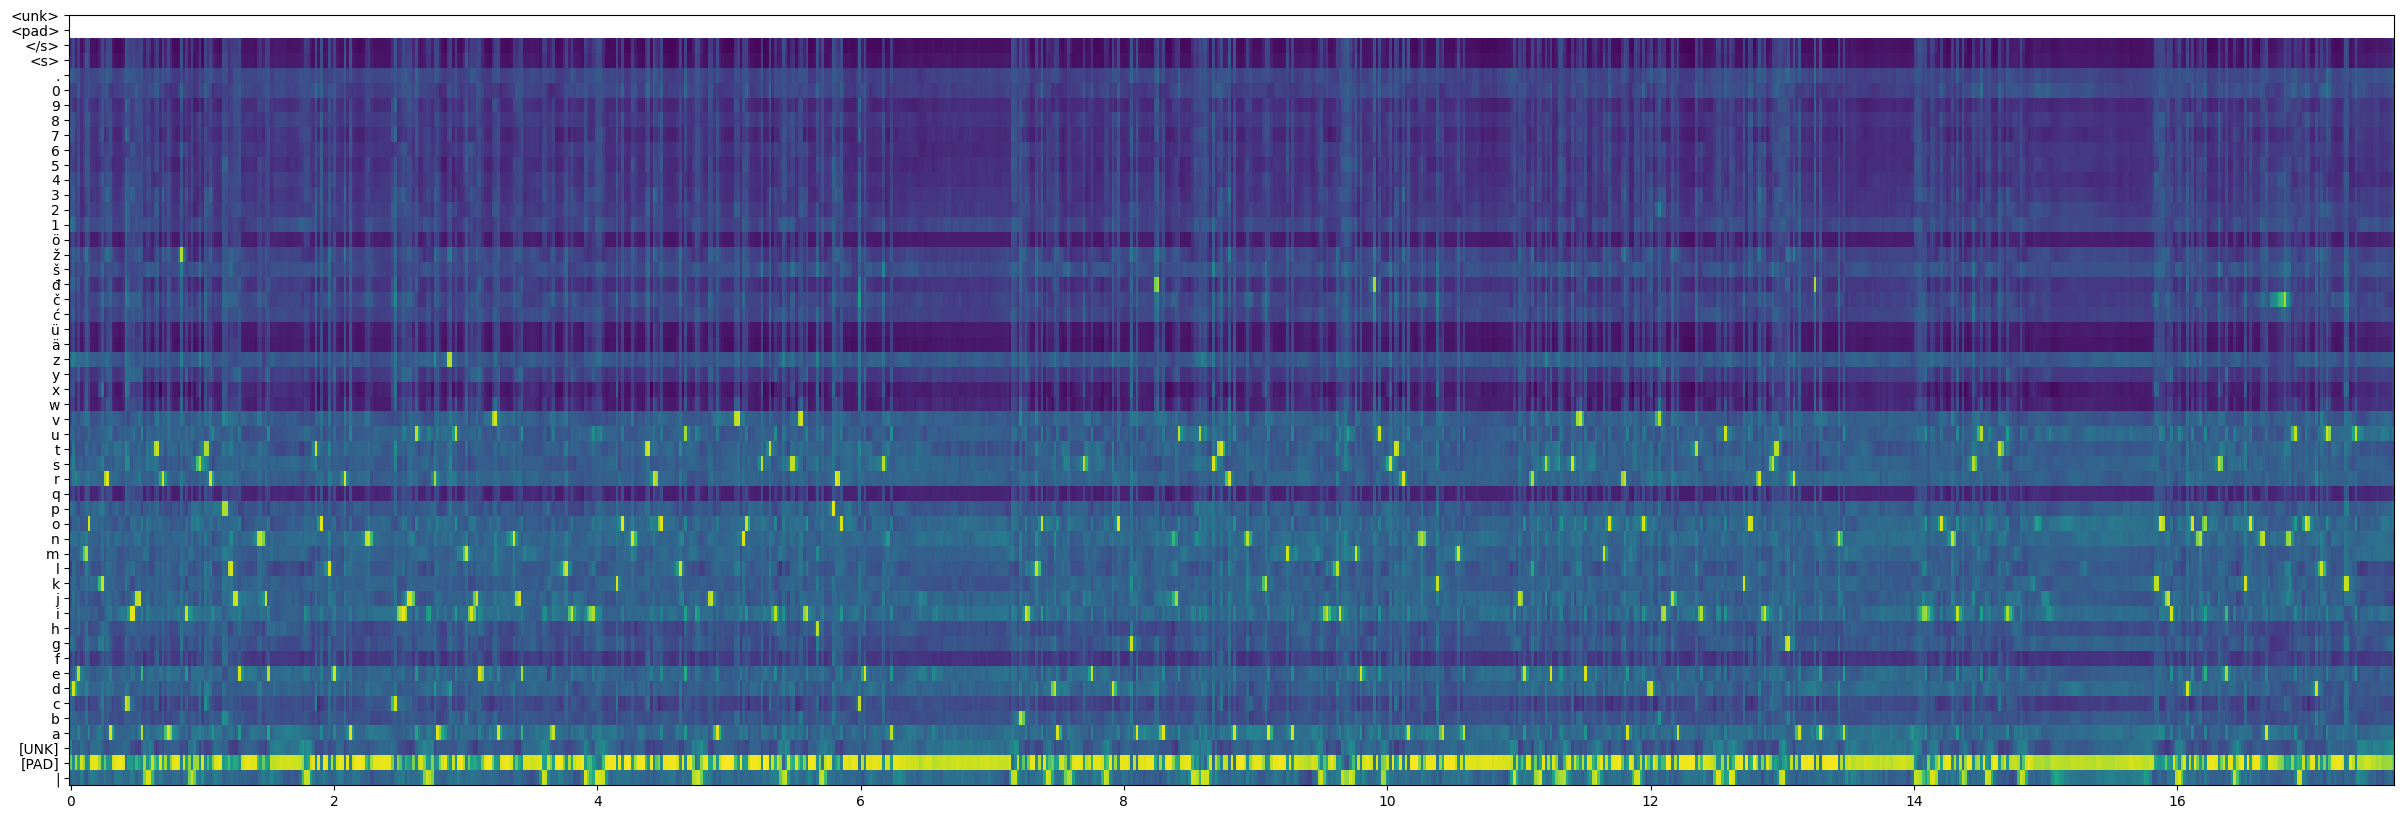

In [10]:
P.figure(figsize=(30, 10))

t = np.linspace(0, audio.size / 16000, logits.shape[0])
l = np.arange(logits.shape[1])

P.pcolormesh(t, l, logits.T)
_ = P.yticks(np.array(list(vocab.values())), list(vocab.keys()))

The Viterbi algorithm implemented below is based on the paper: Rabiner, Lawrence R. "A tutorial on hidden Markov models and selected applications in speech recognition." Proc. IEEE 77 (1989): 257-286.

In [11]:
def viterbi(logits: np.ndarray, labels: np.ndarray, pad_id: int = 0) -> Tuple[List[int], np.ndarray]:
    T = logits.shape[0]
    N = len(labels)
    delta = np.zeros((T, N))
    psi = np.zeros((T, N), dtype=int)

    delta[0, :] = -np.inf
    delta[0, 0] = logits[0][pad_id]

    a = np.zeros((N,))
    b = np.zeros((N,))
    o = np.zeros((N,))
    M = np.arange(N)

    for t in range(1, T):
        delta[t, :] = -np.inf
        beg = np.clip(t - T + N, 0, N - 1)
        end = np.clip(t + 1, 0, N)

        r = np.arange(beg, end)
        ra = np.clip(r, 1, N - 1)

        a[ra] = delta[t - 1][ra - 1]
        b[r] = delta[t - 1][r]

        o[r] = logits[t][labels[r]]
        opad = logits[t][pad_id]

        m = np.zeros(N, dtype=bool)
        m[ra] = (a > b)[ra]
        delta[t][m] = a[m] + o[m]
        psi[t][m] = M[m] - 1

        m = np.zeros(N, dtype=bool)
        m[r] = (a <= b)[r]
        delta[t][m] = b[m] + opad
        psi[t][m] = M[m]

    bestpath = [delta[T - 1].argmax()]
    for t in range(T - 2, -1, -1):
        bestpath.append(psi[t + 1][bestpath[-1]])
    bestpath.reverse()
    return bestpath, delta

To run the algorithm, we use the above label sequence but add a word delimiter token at the start and the end.

In [12]:
lf = (0,) + tuple(labels) + (0,)
bestpath, delta = viterbi(logits, np.array(lf), pad_id=1)

We can draw the forward probabilities of the trellis as color values and use the solid line to represent the best path. The gray areas the locations that cannot be accessed.

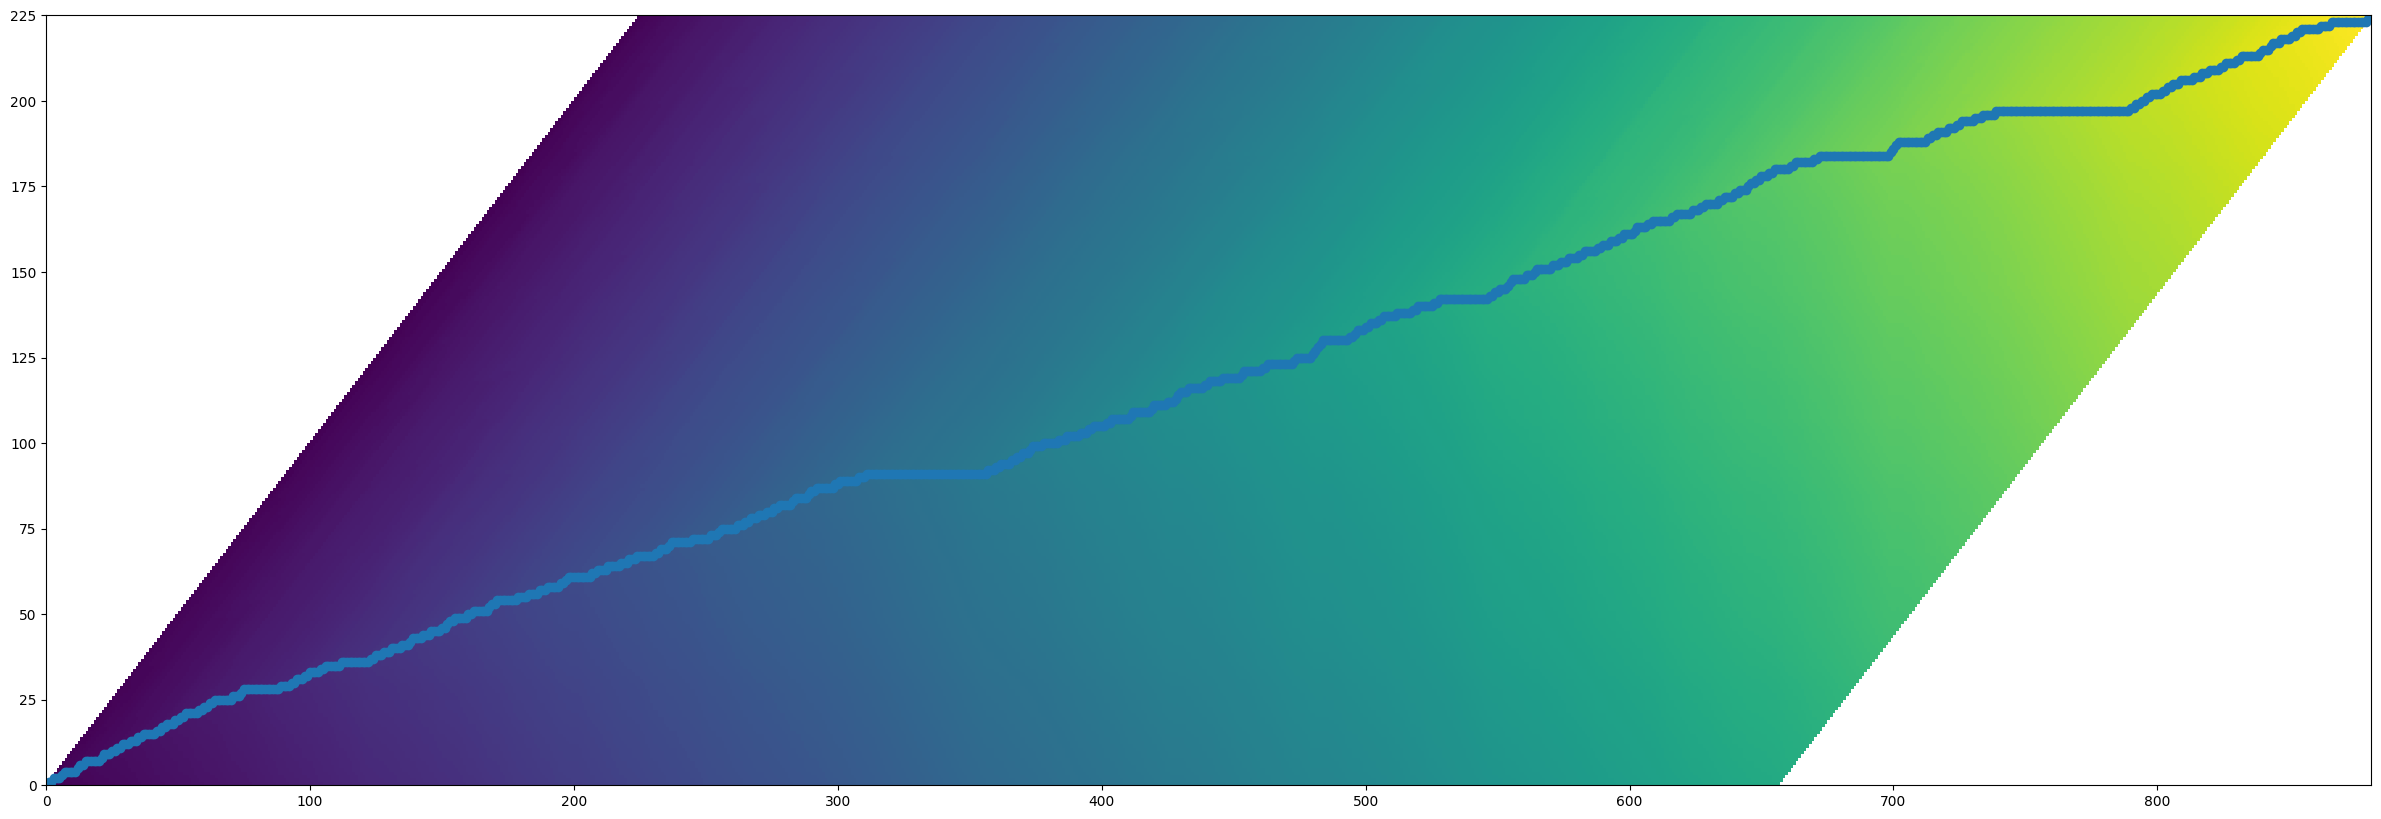

In [13]:
P.figure(figsize=(30, 10))
P.pcolormesh(delta.T)
P.scatter(list(range(logits.shape[0])), bestpath)

Lets get all the individual label timings now:

In [14]:
from transformers.models.wav2vec2.tokenization_wav2vec2 import Wav2Vec2CTCTokenizer

def align_labels(logits: np.ndarray, labels: List[int], tokenizer: Wav2Vec2CTCTokenizer, fr_len: float = 0.02):
    wl_id = tokenizer.word_delimiter_token_id
    pad_id = tokenizer.pad_token_id

    trans = {i:l for l,i in tokenizer.get_vocab().items()}

    labels = (wl_id,) + tuple(labels) + (wl_id,)
    bestpath, _ = viterbi(logits, np.array(labels), pad_id=pad_id)

    ret=[]
    for t,p in enumerate(bestpath):
      l=trans[labels[p]]
      if not ret:
        ret.append({'label':l,'beg':0,'end':fr_len})
      elif ret[-1]['label']==l:
        ret[-1]['end']+=fr_len
      else:
        ret.append({'label':l,'beg':ret[-1]['end'],'end':ret[-1]['end']+fr_len})

    return ret

These are the timings acquired by the above procedure.

In [15]:
label_ali = align_labels(logits, labels, processor.tokenizer)
label_ali

[{'label': '|', 'beg': 0, 'end': 0.02},
 {'label': 'd', 'beg': 0.02, 'end': 0.06},
 {'label': 'e', 'beg': 0.06, 'end': 0.12000000000000001},
 {'label': 'm', 'beg': 0.12000000000000001, 'end': 0.14},
 {'label': 'o', 'beg': 0.14, 'end': 0.23999999999999996},
 {'label': 'k', 'beg': 0.23999999999999996, 'end': 0.25999999999999995},
 {'label': 'r', 'beg': 0.25999999999999995, 'end': 0.3},
 {'label': 'a', 'beg': 0.3, 'end': 0.4200000000000001},
 {'label': 'c', 'beg': 0.4200000000000001, 'end': 0.4400000000000001},
 {'label': 'i', 'beg': 0.4400000000000001, 'end': 0.5000000000000001},
 {'label': 'j', 'beg': 0.5000000000000001, 'end': 0.5400000000000001},
 {'label': 'a', 'beg': 0.5400000000000001, 'end': 0.5800000000000002},
 {'label': '|', 'beg': 0.5800000000000002, 'end': 0.6400000000000002},
 {'label': 't', 'beg': 0.6400000000000002, 'end': 0.7000000000000003},
 {'label': 'r', 'beg': 0.7000000000000003, 'end': 0.7400000000000003},
 {'label': 'a', 'beg': 0.7400000000000003, 'end': 0.84000000

We will also dump the audio file and TextGrid for debugging in Praat or some similar program. You can also use https://ips-lmu.github.io/EMU-webApp/ to view these files.

In [16]:
!pip install pympi-ling

In [17]:
import pympi

tg=pympi.TextGrid(xmax=audio.size/16000)
tier=tg.add_tier('labels')
for l in label_ali:
  tier.add_interval(l['beg'],l['end'],l['label'])
tg.to_file('audio.TextGrid')

In [18]:
import soundfile

soundfile.write("audio.wav", audio, 16000)